# **Hands-On Machine Learning Project**
## **Topic 20: Credit Data**
### Florian Korn, Vincent Bläske, Dennis Götz

***
# **Table of Content**
**[V. Shortlist Models](#shortlist)**<br>
***

## **V. Shortlist Models**  <a id='shortlist'></a>
**[1. Feature Selection and Encoding Pipes](#fsep)**<br>
**[2. Create Train and Test Set](#traintest)**<br>
**[3. Train models with standard parameters](#quickdirty)**<br>

1. Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, kNN, SVM, random forest, neural net, etc.) using standard parameters.
2. Measure and compare their performance:<br>
◦ For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm (e.g., the features with the largest coefficients in a linear regression model).
4. Analyze the types of errors the models make: What data would a human have used to avoid these errors?
5. Perform a quick round of feature selection and engineering.
6. Perform one or two more quick iterations of the five previous steps.
7. Shortlist the top three to five most promising models, preferring models that make different types of errors.
***
### **Import of librariers:**

In [1]:
import pandas as pd
from pandas import get_dummies
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, linear_model, svm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

### **Load stored data:**

In [2]:
%store -r attributes
%store -r num_attribs
%store -r cat_attribs
%store -r binary_attribs
%store -r dict_ordinal_map
%store -r data_values

### **1. Feature Selection and Encoding Pipes** <a id='fsep'></a> <br> 
Here a pipe encoder and selector preprocesses the data.

In [17]:
def pipe_encoder_selector(df: pd.DataFrame(), dict_ordinal_map: dict, columns_excluded: list, cat_attribs: list, binary_attribs: list, num_attribs: list,  target: str, ordinal_encoding = True):
    '''
    This function allows to preprocess a DataFrame with a specific target variable and numerical as also categorical features (with a specific ordering)

    Parameters:
    df : a DataFrame we want to encode and do feature selection
    dict_ordinal_map : a dictionary with the ordered values of categories (specific order)
    columns_excluded : feature selection for the columns we don't want
    cat_attribs : all categorical attributes in our df
    binary_attribs : all binary attributes in our df
    num_attribs : all numerical attribs in our df
    target : target variable (only one possible)
    ordinal_encoding : if all categorical features should be encoded ordinal or one-hot-encoding

    Returns:
    Encoded DataFrame
    '''
    num_pipeline = make_pipeline(
        StandardScaler())
    
    if ordinal_encoding:
        column_cat = [i for i in cat_attribs if (i not in columns_excluded) and (i != target)]
        column_target = [target]
        categories_order = [dict_ordinal_map[i] for i in column_cat]
        cat_pipeline = make_pipeline( 
            OrdinalEncoder(dtype = 'int', categories = categories_order))
    else:
        column_cat = [i for i in cat_attribs if (i not in columns_excluded) and (i != target) and (i not in binary_attribs)]
        column_target = [i for i in cat_attribs if (i not in columns_excluded) and (i not in column_cat)]
        cat_pipeline = make_pipeline(
            OneHotEncoder(dtype = 'int'))
    
    target_pipeline = make_pipeline(
            OrdinalEncoder(dtype = 'int', categories = [dict_ordinal_map[i] for i in column_target]))

    preprocessing = make_column_transformer( 
        (num_pipeline, num_attribs), 
        (cat_pipeline, column_cat),
        (target_pipeline, column_target),
        remainder = 'drop', verbose_feature_names_out = False)

    X = preprocessing.fit_transform(df)
    df_encoded = pd.DataFrame(
                        X, 
                        columns = preprocessing.get_feature_names_out(),
                        index = df.index
                        )
    return df_encoded

columns_excluded = ['foreign worker', 'Personal status and sex']
data_encoded_ord = pipe_encoder_selector(data_values, dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', True)
data_encoded_onehot = pipe_encoder_selector(data_values, dict_ordinal_map, columns_excluded, cat_attribs, binary_attribs, num_attribs, 'Credit rating', False)

display(data_encoded_ord.head(3))
display(data_encoded_onehot.head(3))

,Age in years,Number of existing credits at this bank,Installment rate in percentage of disposable income,Present residence since,Duration in month,Credit amount,Number of people being liable to provide maintenance for,Status of existing checking account,Credit history,Purpose,Savings account/bonds,Present employment since,Other debtors / guarantors,Property,Other installment plans,Housing,Job,Telephone,Credit rating
0,2.766456,1.027079,0.918477,1.046987,-1.236478,-0.745131,-0.428290,1.0,4.0,3.0,0.0,4.0,0.0,3.0,0.0,2.0,2.0,0.0,0.0
1,-1.191404,-0.704926,-0.870183,-0.765977,2.248194,0.949817,-0.428290,2.0,2.0,3.0,1.0,2.0,0.0,3.0,0.0,2.0,2.0,1.0,1.0
2,1.183312,-0.704926,-0.870183,0.140505,-0.738668,-0.416562,2.334869,0.0,4.0,6.0,1.0,3.0,0.0,3.0,0.0,2.0,1.0,1.0,0.0


,Age in years,Number of existing credits at this bank,Installment rate in percentage of disposable income,Present residence since,Duration in month,Credit amount,Number of people being liable to provide maintenance for,Status of existing checking account_... < 0 DM,Status of existing checking account_... >= 200 DM / salary assignments for at least 1 year,Status of existing checking account_0 <= ... < 200 DM,...,Other installment plans_stores,Housing_for free,Housing_own,Housing_rent,Job_management/ self-employed/ highly qualified employee/ officer,Job_skilled employee / official,Job_unemployed/ unskilled - non-resident,Job_unskilled - resident,Telephone,Credit rating
0,2.766456,1.027079,0.918477,1.046987,-1.236478,-0.745131,-0.428290,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.191404,-0.704926,-0.870183,-0.765977,2.248194,0.949817,-0.428290,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,1.183312,-0.704926,-0.870183,0.140505,-0.738668,-0.416562,2.334869,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


### **2. Create Train and Test Set** <a id='traintest'></a> <br> 

In [18]:
# Create a Test Set with ordinal encoding
train_set, test_set = train_test_split(data_encoded_ord, train_size=0.8, random_state=0, stratify=data_values['Credit rating'])

# Separate features and target values in train and test set
X_train_ordinal = np.array(train_set.iloc[:, :-1])
y_train_ordinal = np.array(train_set.iloc[:, -1])
X_test_ordinal = np.array(test_set.iloc[:, :-1])
y_test_ordinal = np.array(test_set.iloc[:, -1])

In [19]:
# Create a Test Set with one-hot-encoding
train_set, test_set = train_test_split(data_encoded_onehot, train_size=0.8, random_state=0, stratify=data_values['Credit rating'])

# Separate features and target values in train and test set
X_train_onehot = np.array(train_set.iloc[:, :-1])
y_train_onehot = np.array(train_set.iloc[:, -1])
X_test_onehot = np.array(test_set.iloc[:, :-1])
y_test_onehot = np.array(test_set.iloc[:, -1])

### **3. Train models with standard parameters** <a id='quickdirty'></a> <br>
Create the Pipelines with the quick and dirty models.

In [20]:
# Create Pipelines

# Linear Models
## Linear Regression
pipe_reg = Pipeline([('reg', LinearRegression())])

## Ridge Regression
pipe_ridgereg = Pipeline([('scaler', StandardScaler()),
                          ('ridgereg', linear_model.Ridge())])

## Lasso Regression
pipe_lassoreg = Pipeline([('scaler', StandardScaler()),
                          ('lassoreg', linear_model.Lasso())])

## Logistic Regression
pipe_logreg = Pipeline([('scaler', StandardScaler()),
                        ('logreg', LogisticRegression())])

# kNN
pipe_knn = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsClassifier())])

# naiveBayes
pipe_gaussiannb = Pipeline([('gaussiannb', GaussianNB())])

# Support Vector Machine
pipe_svm = Pipeline([('scaler', StandardScaler()),
                     ('svm', svm.SVC())])

# Random Forest
pipe_rf = Pipeline([('rf', RandomForestClassifier())])

# Decision Tree
pipe_decisiontree = Pipeline([('decisiontree', tree.DecisionTreeClassifier())])

# Neural Network Classifier
pipe_neuralnetwork = Pipeline([('scaler', StandardScaler()),
                               ('neuralnetwork', MLPClassifier())])


Compute the scores of the pipelines with the quick and dirty models.

For ordinal encoded data:


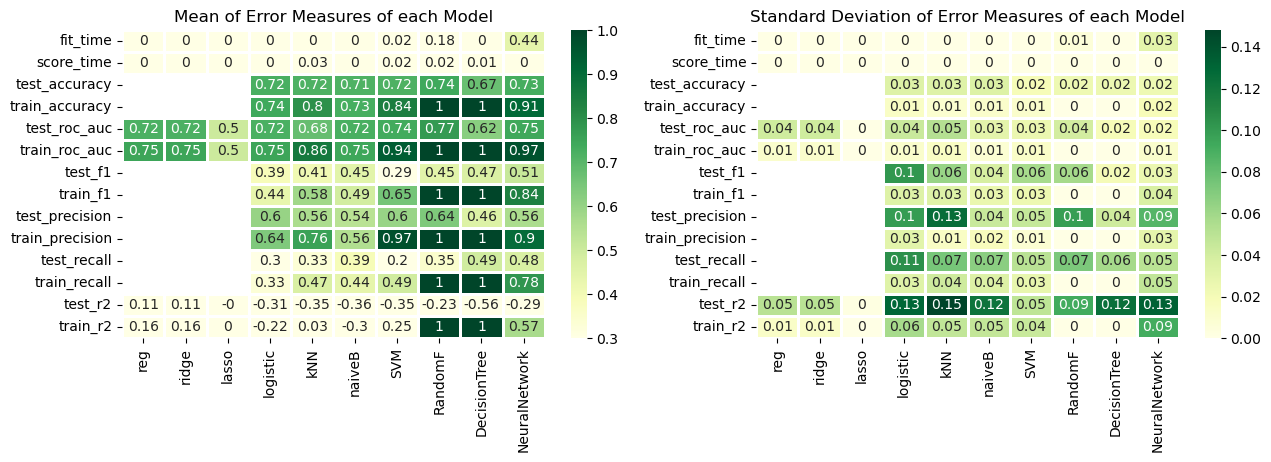

For one-hot encoded data:


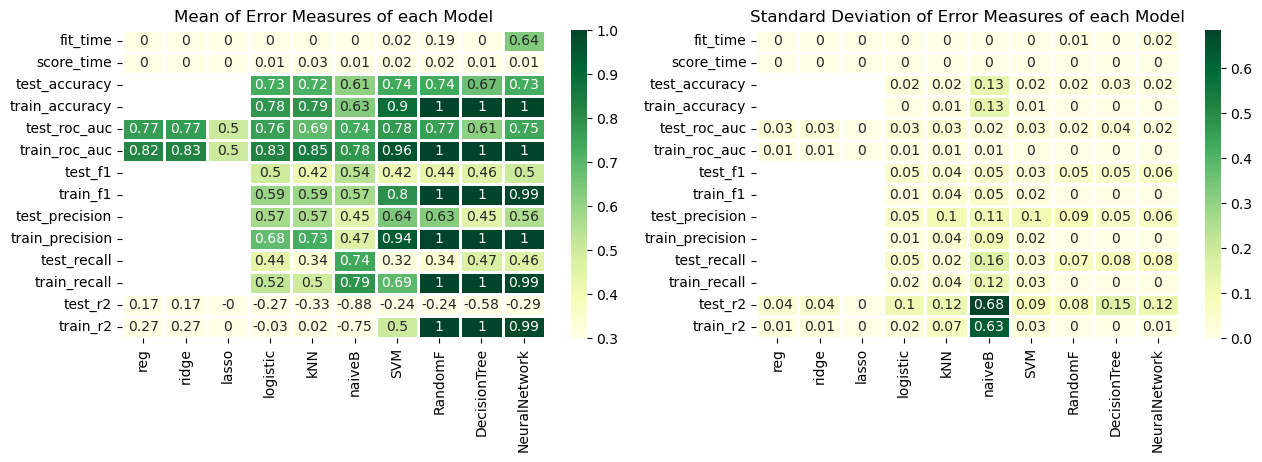

In [41]:
# K Fold iterator
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# List of pipelines
pipeline_list = [pipe_reg,
                 pipe_ridgereg,
                 pipe_lassoreg,
                 pipe_logreg,
                 pipe_knn,
                 pipe_gaussiannb,
                 pipe_svm,
                 pipe_rf,
                 pipe_decisiontree,
                 pipe_neuralnetwork]

# compute scores of quick and dirty models
def score_quick_models(X_train, y_train, pipeline_list):
    '''
    This function computes the error measures of quick and dirty models.

    Parameters:
    X_train : the training data with all features
    y_train : the training data with the target variable
    pipeline_list : all pipelines

    Returns:
    Two heatmaps with the mean and standard deviation of the error measures
    '''
    scores_mean = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                                X_train,
                                                                y_train,
                                                                scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                                cv=kfold,
                                                                n_jobs=-1,
                                                                return_train_score=True)).mean(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
    scores_std = pd.concat([pd.DataFrame(pd.DataFrame(cross_validate(pipeline_list[i], 
                                                                X_train,
                                                                y_train,
                                                                scoring=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'r2'],
                                                                cv=kfold,
                                                                n_jobs=-1,
                                                                return_train_score=True)).std(), columns = [i]) for i in range(len(pipeline_list))], axis = 1)
    scores_mean.columns = ['reg', 'ridge', 'lasso', 'logistic', 'kNN', 'naiveB', 'SVM', 'RandomF', 'DecisionTree', 'NeuralNetwork']
    scores_std.columns = ['reg', 'ridge', 'lasso', 'logistic', 'kNN', 'naiveB', 'SVM', 'RandomF', 'DecisionTree', 'NeuralNetwork']

    # Visualize scores
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,4))
    g1 = sns.heatmap(scores_mean, vmin = 0.3, vmax = 1, center = 0.65, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores_mean, 2), ax = ax1)
    ax1.title.set_text('Mean of Error Measures of each Model')
    g2 = sns.heatmap(scores_std, linewidth = 1, linecolor = 'white', cmap = 'YlGn', annot = np.round(scores_std, 2), ax = ax2)
    ax2.title.set_text('Standard Deviation of Error Measures of each Model')
    plt.show()

print('For ordinal encoded data:')
score_quick_models(X_train_ordinal, y_train_ordinal, pipeline_list)
print('For one-hot encoded data:')
score_quick_models(X_train_onehot, y_train_onehot, pipeline_list)

**Overall**<br>
Between the error measures of the one-hot encoded data and the ordinal encoded data, we see that the neural network and SVM performs better when one-hot encoded.<br><br>
**Regression Models**<br>
The R2 for ordinal encoded data is between 0 and 11 % and for one-hot-encoded data between 0 and 27 %. In both cases lasso performs bad.<br> 
General the regression models don't have a good performance . This could be that we haven't tuned the models yet. But we have a classification task that needs to predict classes and not continuous values, so the regression models are not appropriate.<br>

For the following models, the R2 should be ignored as it is an error measure to validate the prediction of continuous variables. It is worse to classify a customer as good (0) when they are bad (1) than it is to classify a customer as bad when they are good (1). The metrics that describe this well are recall (the proportion of true positives among all positives) and roc auc, which describes the area under the curve; if it is 1, we separate the classes perfectly and therefore identify true positives with a very high probability.<br><br>
**Logistic Regression**<br>
For the logistic regression the R2 should not b
